# <center> Learning to Act - Session 1</center>

# Activity 0. Setup

#### Install additional dependencies

Let us first make sure that all the required dependencies are installed

In [1]:
import sys
!{sys.executable} -m pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.8 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/rvss-australia/RVSS.git

Cloning into 'RVSS'...
remote: Enumerating objects: 1239, done.
remote: Counting objects: 100% (341/341), done.
remote: Compressing objects: 100% (201/201), done.
remote: Total 1239 (delta 185), reused 280 (delta 135), pack-reused 898
Receiving objects: 100% (1239/1239), 173.52 MiB | 16.69 MiB/s, done.
Resolving deltas: 100% (615/615), done.
Updating files: 100% (259/259), done.


In [3]:
import os
print(os.getcwd())
os.chdir("./RVSS/Reinforcement_Learning/")

/content


#### Import dependencies

In [4]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pickle
import math

import sys
import os

from RL_Support.gym_simple_gridworlds.helper import *
from RL_Support.gym_simple_gridworlds.envs.grid_env import GridEnv
from RL_Support.gym_simple_gridworlds.envs.grid_2dplot import *

from collections import namedtuple, defaultdict
import matplotlib.gridspec as gridspec

from IPython.display import display, HTML

UP = 0; DOWN = 1; LEFT = 2; RIGHT = 3; STAY = np.nan

# Activity 1. Elements of an MDP (Grid World Example)

Recall the grid in which our robot lives

![GridWorldExample.png](https://i.postimg.cc/5tMM5vqf/Grid-World-Example.png)

- The states $s \in \mathcal{S}$ correspond to locations in the grid. Each location has also a cell index associated to it, e.g., cell index 4 is associated to location (row=1,col=0)
- The robot can move up, down, left, or right. Actions correpond to unit increments or decrements in the specified direction.
    - Up : (-1,0)
    - Down: (1,0)
    - Left: (0,-1)
    - Right: (0, 1)
- Each action is represented by a number. Action (Up) is represented by 0, (Down) by 1, (Left) by 2 and, finally, (Right) by 3. No actions are available at a terminal state

## Create Environment and Explore its Attributes

The noise parameter corresponds to the probability of a change of direction when an action is taken (e.g., going left/right when agent decides to move up/down)

In [5]:
# Create a Grid World instance
grid_world = GridEnv(gamma=0.9, noise=0.2, living_reward=-0.04)

### State and Action Spaces

Let's take a look at the state and action spaces of our environment

In [6]:
# State (or observation) space
print(grid_world.observation_space)
print(grid_world.get_states())
print()

# Action space
print(grid_world.action_space)
print(grid_world.get_actions())

Discrete(11)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Discrete(4)
[0, 1, 2, 3]


### Transition Function

Let's take a look at the current state transition function. Some things to keep in mind regarding the transition function:

1. Given that $\mathcal{T}: \mathcal{S} \times \mathcal{A} \times \mathcal{S} \rightarrow \mathbb{R}$, the ``state_transitions`` attribute of the class ``GridEnv`` corresponds to a 3-Dimensional numpy array of size $11\times4\times11$.
2. With a noise attribute set to 0.2, at state 5, if the agent chooses to move up, it will end up at:
    - state 2 with $80\%$ probability,
    - state 6 with $10\%$ probability, or
    - state 5 with $10\%$ probability

In [8]:
# at state 5 the agent takes action 0 (going up)
print(grid_world.state_transitions[9,0])

[0.  0.  0.  0.  0.  0.8 0.  0.  0.1 0.  0.1]


### Policy

Let's see the path of an agent moving on our grid world according to the following policy $\pi$

![example_policy.png](https://i.postimg.cc/pLjHnkj0/example-policy.png)

In [9]:
# We represent this policy as a 2-Dimensional numpy array
policy_matrix = np.array([[3,      3,  3,  -1],
                          [0, np.NaN,  0,  -1],
                          [0,      2,  0,   2]])

Let's now apply this policy and observe the agent's behavior (blue dot in the figure shown below).

In [10]:
# Create a Grid World instance
grid_world = GridEnv(gamma=0.9, noise=0.2, living_reward=-0.04)
s_x, s_y = get_state_to_plot(grid_world)

# We can visualize our grid world using the render() function
fig, ax = grid_world.render()
agent, = ax.plot([], [], 'o', color='b', linewidth=6)
reward_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

done = False
cumulative_reward = 0
cur_state = grid_world.cur_state
path_to_plot = []

while not done:
    _, cur_reward, done, _ = grid_world.step(int(policy_matrix[cur_state[0], cur_state[1]]))
    cur_state = grid_world.cur_state
    n_x, n_y = get_state_to_plot(grid_world)
    cumulative_reward += cur_reward
    path_to_plot.append([cumulative_reward, n_x, n_y])

def init():
    agent.set_data(s_x + 0.5, s_y + 0.5)
    reward_text.set_text('')
    return agent, reward_text

def animate(i):
    if i < len(path_to_plot):
        r, n_x, n_y = path_to_plot[i]
        agent.set_data(n_x + 0.5, n_y + 0.5)
        reward_text.set_text('Cumulative reward: %.2f' % r)
    return agent, reward_text

ani = animation.FuncAnimation(fig, animate, frames=len(path_to_plot), blit=False, interval=500, init_func=init,
                              repeat=False)

plt.close('all')
display(HTML(f"<div align=\"center\">{ani.to_jshtml()}</div>"))

<ipython-input-10-98d8c6d15242>:23: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent.set_data(s_x + 0.5, s_y + 0.5)
<ipython-input-10-98d8c6d15242>:30: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent.set_data(n_x + 0.5, n_y + 0.5)


**Behavioural Cloning**

We would like to learn this policy from demonstrations.  Let's collect a dataset of demonstrations

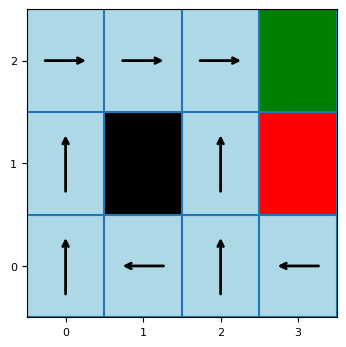

In [11]:
Sample = namedtuple('Sample', ['state', 'action', 'reward', 'next_state'])
grid_world = GridEnv(gamma=0.9, noise=0.0, living_reward=-0.04, width = 4, height = 3)
# value_function, expert_policy = value_iteration(grid_world)

# We represent the expert's policy as a 2-Dimensional numpy array
expert_policy = np.array([[RIGHT, RIGHT,  RIGHT,  STAY],
                          [UP,    STAY,   UP,     STAY],
                          [UP,    LEFT,   UP,     LEFT]])

plot_policy(grid_world, expert_policy)


# We allow for the expert demonstration to be noisy
def get_noisy_policy(env, state, policy, noise):
    x, y = np.argwhere(env.grid == state)[0]
    optimal_action = int(policy[x, y])
    if np.random.rand() < noise:
        action = np.random.choice([a for a in env.get_actions() if a != optimal_action])
    else:
        action = optimal_action
    return action

# A helper function to generate one demonstration (one episode)
def generate_noisy_policy_episode(env, policy, initial_state, noise):

    # handle initial_state input, can accept both tuple or integer
    if isinstance(initial_state, int):
        if initial_state in grid_world.get_states():
            state = initial_state
        else:
            raise RuntimeError("state is invalid")
    elif (isinstance(initial_state, tuple)
          and len(initial_state) == 2
          and all(isinstance(item, int) for item in initial_state)):
        state = int(env.grid[initial_state])
    else:
        raise TypeError("Argument must be an integer or a list of two integers.")

    # Episode generation with specified initial_state
    episode = []
    env.cur_state = tuple(np.argwhere(env.grid == state)[0])
    env.idx_cur_state = state
    done = False

    while not done:
        action = get_noisy_policy(env, state, policy, noise)
        next_state, reward, done, info = env.step(action)
        episode.append(Sample(state, action, reward, next_state))
        state = next_state

    return episode


# Generate the epsiodes
N_episodes = 100
episodes = []
for i in range(N_episodes):
    episodes.append(generate_noisy_policy_episode(env = grid_world,
                                                  policy = expert_policy,
                                                  initial_state = (0, 0),
                                                  noise = 0.3))
# for i in range(N_episodes):
#     episodes.append(generate_noisy_policy_episode(env = grid_world,
#                                                   policy = expert_policy,
#                                                   initial_state = 7,
#                                                   noise = 0.3))

Now we will learn the robot's policy directly from these demonstrations


<Axes: >

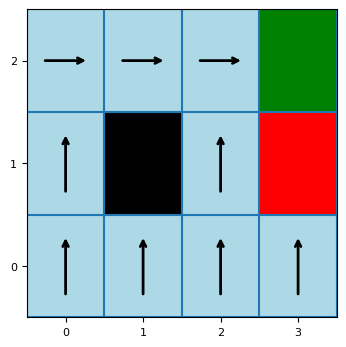

In [12]:
def behaviour_cloning(env, episodes):
    counted_actions = np.zeros((len(grid_world.get_states()), len(grid_world.get_actions())))
    for episode in episodes:
        for obs in episode:
            counted_actions[obs.state, obs.action] += 1
    policy = deepcopy(env.grid)
    policy[~np.isnan(policy)] = np.argmax(counted_actions, axis = 1)
    return policy, counted_actions

policy, counted_actions = behaviour_cloning(grid_world, episodes)
plot_policy(grid_world, policy)

In [13]:
import plotly.graph_objects as go
import numpy as np

def plot_policy_stats(env, counted_actions):
    height, width = env.grid.shape
    hover_text = [["" for _ in range(width)] for _ in range(height)]
    data = np.zeros((height, width))
    for i in range(height):
        for j in range(width):
            if env.is_obstacle(i, j):
                hover_text[i][j] = "obstacle"
                data[i, j] = 0
            elif env.is_terminal_state(i, j):
                hover_text[i][j] = "terminal_state"
                data[i, j] = 0
            else:
                state = int(env.grid[i, j])
                n_visits = np.sum(counted_actions[state])
                hover_text[i][j] = (f"state: {state}<br>"
                                f"total visits: {n_visits}<br>"
                                f"UP: {counted_actions[state][UP]}<br>"
                                f"DOWN: {counted_actions[state][DOWN]}<br>"
                                f"LEFT: {counted_actions[state][LEFT]}<br>"
                                f"RIGHT: {counted_actions[state][RIGHT]}")
                data[i, j] = n_visits

    # Create a heatmap for the grid
    fig = go.Figure(data=go.Heatmap(
        z=data[::-1],
        x=np.arange(1, width+1),
        y=np.arange(1, height+1),
        hoverinfo='text',
        text=hover_text[::-1],
        showscale=False,  # Hide the color scale bar
        colorscale='bluered'  # Color scheme, can be customized
    ))

    # Update layout to better represent a grid of squares
    fig.update_layout(
        xaxis=dict(tickmode='linear', showticklabels = False),
        yaxis=dict(tickmode='linear', showticklabels = False),
        xaxis_showgrid=False,
        yaxis_showgrid=False,
        height=600,
        width=600,
        title="Heat Map of visited states and action"
    )

    # Preventing axis from being squished
    fig.update_xaxes(scaleanchor="y", scaleratio=1)

    # Show the figure
    fig.show()


plot_policy_stats(grid_world, counted_actions)